**Задание 3**  

В пакете для третьего задания три файла:
В файле ***Tariff_plans_change.csv*** содержатся выборочные данные о транзакциях, связанных с подключениями и отключениями тарифных планов абонентами, которые меняли тарифные планы в первом полугодии 2017 года: 

SUBSCRIBER_ID	 -  условный идентификатор абонента

TARIFF_PLAN_ID – условный идентификатор тарифного плана	

START_DTTM	 - дата и время подключения плана

END_DTTM – дата и время отключения (значение $null$ означает, что план актуален на текущий момент).

В файле ***Charges.csv*** содержатся помесячные исторические данные об общих расходах абонентов на мобильную связь:

SUBSCRIBER_ID	 -  условный идентификатор абонента

BILL_MONTH – биллинговый период в формате YYYY-MM-01 (например, строки со значением ‘2016-01-01’ содержат данные о расходах и потреблении за январь 2016 года)

CHARGES – общая сумма  счета за услуги связи

В файле ***Suspended.csv*** содержатся исторические данные о блокировках абонентов в транзакционной форме:

SUBSCRIBER_ID	 -  условный идентификатор абонента

START_DT - дата начала блокировки

END_DT – дата окончания блокировки (значение $null$ означает, что абонент остается блокированным на текущий момент).

**Необходимо исследовать следующие вопросы:**

1)	Направления смен тарифных планов: с каких тарифных планов и на какие шли  наибольшие перетоки? Визуализировать потоки миграций на диаграмме. 

2)	Насколько изменился среднемесячный счет абонентов за период 3 месяца после месяца смены тарифного плана в сравнении с периодом 3 месяца до месяца смены тарифного плана. Какие направления смен тарифных планов характеризовались ростом среднего счета в трехмесячном периоде, а какие – сокращением.  Визуализировать результаты на диаграммах.

3)	Аналогично п.2, только относительно изменения уровня блокировок: насколько реже или чаще стали попадать в блокировки абоненты после миграции в целом и для каждого направления миграции в отдельности. Для сравнения использовать те же периоды: 3 месяца до месяца смены плана и 3 месяца после месяца смены.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import warnings
from pandas.tseries.offsets import MonthBegin, MonthEnd
warnings.filterwarnings('ignore')

In [2]:
tariff_plans_change = pd.read_csv("Tariff_plans_change.csv")
charges = pd.read_csv("Charges.csv")
suspended = pd.read_csv("Suspended.csv")

In [3]:
#Приведем все названия столбцов к нижнему регистру
tariff_plans_change.columns = tariff_plans_change.columns.str.lower()

In [4]:
#Преобразуем столбцы с датами к типу данных datetime
tariff_plans_change['start_dttm'] =  pd.to_datetime(tariff_plans_change['start_dttm'], format='%Y-%m-%d').dt.date
tariff_plans_change['end_dttm'] =  pd.to_datetime(tariff_plans_change['end_dttm'], format='%Y-%m-%d', errors='coerce').dt.date

**Направление смен тарифных планов**

In [5]:
tariff_plans_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12344 entries, 0 to 12343
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subscriber_id   12344 non-null  int64 
 1   tariff_plan_id  12344 non-null  int64 
 2   start_dttm      12344 non-null  object
 3   end_dttm        6406 non-null   object
dtypes: int64(2), object(2)
memory usage: 385.9+ KB


In [6]:
tariff_plans_change.head()

,subscriber_id,tariff_plan_id,start_dttm,end_dttm
0,1,2,2013-11-22,2017-03-11
1,1,3,2017-03-11,NaT
2,2,1,2016-02-05,2017-06-29
3,2,5,2017-06-29,NaT
4,3,1,2015-05-06,2017-04-14


In [7]:
changes = sorted(tariff_plans_change['tariff_plan_id'].unique())
print(f"Уникальные тарифные планы:", changes)

Уникальные тарифные планы: [1, 2, 3, 4, 5]


In [8]:
tariff_plans_change['subscriber_id'].value_counts()

5929    18
5905    16
2144     8
1524     6
5089     6
        ..
2038     2
2037     2
2036     2
2035     2
5989     2
Name: subscriber_id, Length: 5989, dtype: int64

In [9]:
#Сводная таблица, которая содержит информацию о дате преращения конкретного тарифа и количеству абонентов, которые с данного тарифа ушли
subscribers_left = pd.pivot_table(tariff_plans_change, index=['end_dttm', 'tariff_plan_id'], values=['subscriber_id'], aggfunc='count')

In [10]:
subscribers_left

subscriber_id
end_dttm   tariff_plan_id               
2017-01-01 1                           4
           3                          15
           4                           1
           5                           1
2017-01-02 1                          14
...                                  ...
2018-01-18 2                           1
           4                           2
2018-01-19 1                           1
           4                           1
           5                           3

[848 rows x 1 columns]

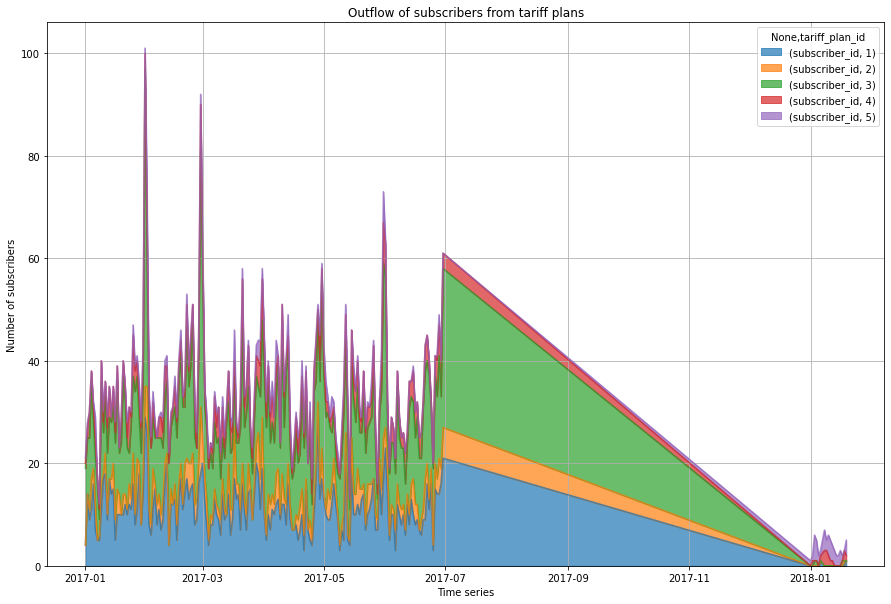

In [11]:
ax = subscribers_left.unstack().plot(
    kind='area', 
    figsize=(15,10),
    grid=True,
    alpha=0.7,
    legend=True,
    xlabel="Time series",
    ylabel="Number of subscribers",
    title="Outflow of subscribers from tariff plans"
)

In [12]:
#Сводная таблица, которая содержит информацию о дате подключения к конкретному тарифу и количеству абонентов, которые пришли на данный тариф
subscribers_came = pd.pivot_table(tariff_plans_change, index=['start_dttm', 'tariff_plan_id'], values=['subscriber_id'], aggfunc='count')

In [13]:
subscribers_came

subscriber_id
start_dttm tariff_plan_id               
1999-07-12 3                           1
1999-08-06 3                           1
1999-09-10 1                           1
1999-11-04 1                           1
1999-12-13 3                           1
...                                  ...
2017-06-27 5                          39
2017-06-28 1                           2
           5                          48
2017-06-29 5                          40
2017-06-30 5                          61

[4352 rows x 1 columns]

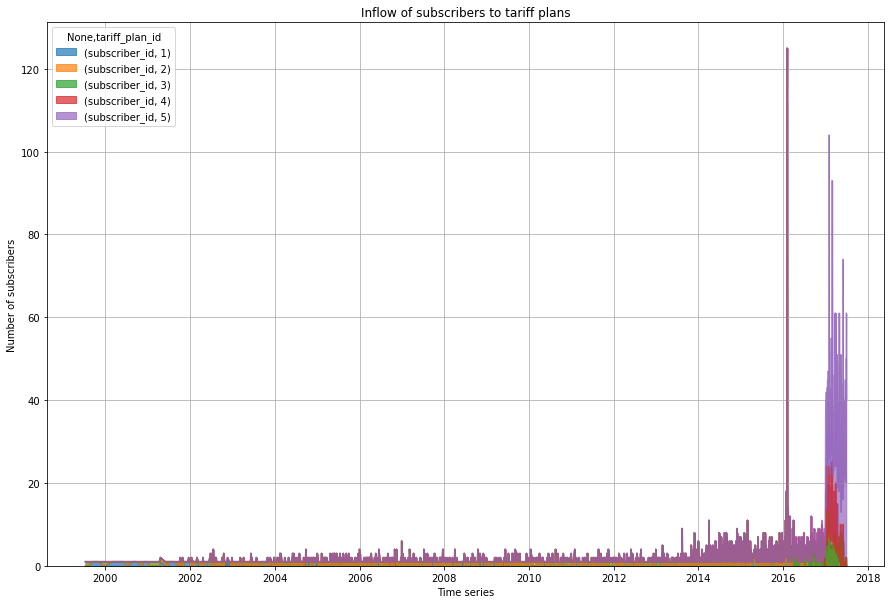

In [14]:
subscribers_came.unstack().plot(
    kind='area',
    figsize=(15,10),
    grid=True,
    alpha=0.7,
    legend=True,
    xlabel="Time series",
    ylabel="Number of subscribers",
    title="Inflow of subscribers to tariff plans"
)
plt.show()

In [15]:
subscribers_came1 = subscribers_came.unstack().reset_index()

In [16]:
subscribers_came1['start_dttm'] = pd.to_datetime(subscribers_came1['start_dttm'], format='%Y-%m-%d' )

In [17]:
subscribers_came1.index = subscribers_came1['start_dttm']

In [18]:
subscribers_came1 = subscribers_came1.drop('start_dttm', axis=1)

In [19]:
subscribers_came1 = subscribers_came1.loc['2017-01-01':, :]

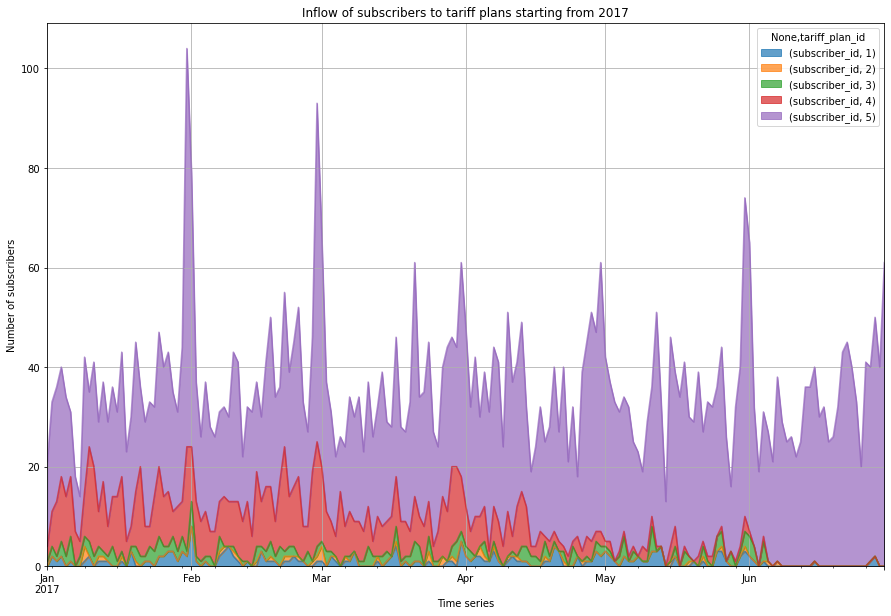

In [20]:
subscribers_came1.plot(
    kind='area',
    figsize=(15,10),
    alpha=0.7,
    grid=True,
    xlabel="Time series",
    ylabel="Number of subscribers",
    title="Inflow of subscribers to tariff plans starting from 2017"
)
plt.show()

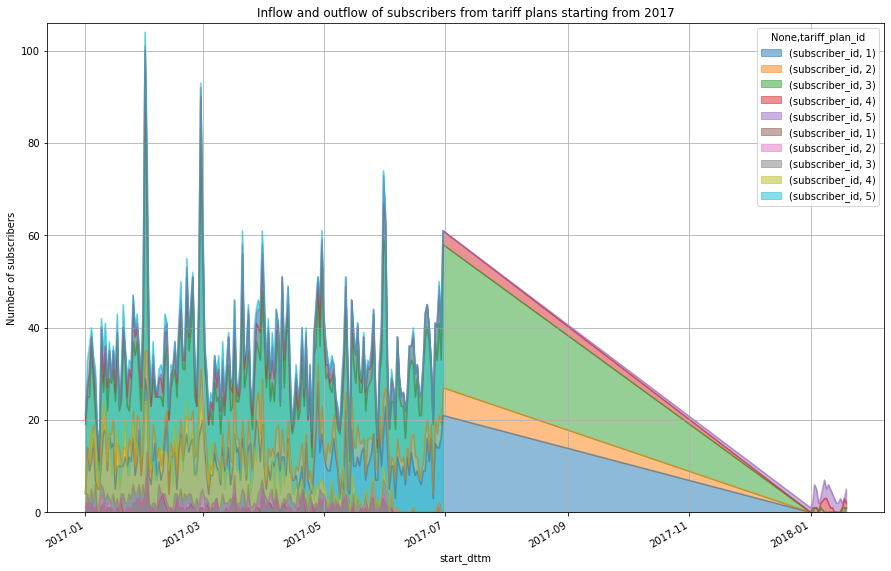

In [21]:
#Отобразим на одной диаграмме 2 графика притока и оттока с тарифных планов
ax = subscribers_left.unstack().plot(
    kind='area', 
    figsize=(15,10),
    grid=True,
    alpha=0.5,
    legend=True,
    xlabel="Time series",
    ylabel="Number of subscribers",
    title="Inflow and outflow of subscribers from tariff plans starting from 2017"
)
subscribers_came1.plot(
    kind='area',
    figsize=(15,10),
    alpha=0.5,
    grid=True,
    ax=ax
)
plt.show()

**Изменение среднемесячного счета абонентов**

Насколько изменился среднемесячный счет абонентов за период 3 месяца после месяца смены тарифного плана в сравнении с периодом 3 месяца до месяца смены тарифного плана. Какие направления смен тарифных планов характеризовались ростом среднего счета в трехмесячном периоде, а какие – сокращением. Визуализировать результаты на диаграммах.

In [22]:
charges.columns = charges.columns.str.lower()

In [23]:
charges['bill_month'] = pd.to_datetime(charges['bill_month'], format='%Y-%m-%d')

In [24]:
charges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112595 entries, 0 to 112594
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   subscriber_id  112595 non-null  int64         
 1   bill_month     112595 non-null  datetime64[ns]
 2   charges        112595 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.6 MB


In [25]:
charges.head()

,subscriber_id,bill_month,charges
0,4741,2017-03-01,4.572
1,1754,2017-05-01,4.894
2,381,2017-01-01,6.670
3,5832,2016-12-01,4.299
4,5277,2017-03-01,1.610


In [26]:
mean_bills = pd.DataFrame(charges.groupby('bill_month')['charges'].mean())

In [27]:
mean_bills.head()

,charges
bill_month,
2016-06-01,7.565184
2016-07-01,7.682829
2016-08-01,7.773045
2016-09-01,7.676724
2016-10-01,8.056758


In [28]:
tariff_plans_change.head()

,subscriber_id,tariff_plan_id,start_dttm,end_dttm
0,1,2,2013-11-22,2017-03-11
1,1,3,2017-03-11,NaT
2,2,1,2016-02-05,2017-06-29
3,2,5,2017-06-29,NaT
4,3,1,2015-05-06,2017-04-14


In [29]:
tariff_plans_change['date_before_3_months'] = tariff_plans_change[tariff_plans_change['end_dttm'].notna()]['end_dttm'] - relativedelta(months=+3)
tariff_plans_change['date_after_3_months'] = tariff_plans_change[tariff_plans_change['end_dttm'].notna()]['end_dttm'] + relativedelta(months=+3)

In [30]:
tariff_plans_change['date_after_3_months1'] = tariff_plans_change['start_dttm'] + relativedelta(months=+3)

In [31]:
tariff_plans_change['date_before_3_months'] = pd.to_datetime(tariff_plans_change['date_before_3_months'], format='%Y-%m-%d', errors='coerce')
tariff_plans_change['date_after_3_months'] = pd.to_datetime(tariff_plans_change['date_after_3_months'], format='%Y-%m-%d', errors='coerce')
tariff_plans_change['date_after_3_months1'] = pd.to_datetime(tariff_plans_change['date_after_3_months1'], format='%Y-%m-%d')

In [32]:
tariff_plans_change['date_before_3_months'] = tariff_plans_change['date_before_3_months'] + pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin()
tariff_plans_change['date_after_3_months'] = tariff_plans_change['date_after_3_months'] + pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin()
tariff_plans_change['date_after_3_months1'] = tariff_plans_change['date_after_3_months1'] + pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin()

In [33]:
date_before_after_3_months = tariff_plans_change[['subscriber_id', 'date_before_3_months', 'date_after_3_months', 'tariff_plan_id']]
date_before_after_3_months = date_before_after_3_months[date_before_after_3_months['date_before_3_months'].notna()]

In [34]:
temp = tariff_plans_change[['subscriber_id', 'date_after_3_months1', 'tariff_plan_id']]
total_change = date_before_after_3_months.merge(temp, left_on=['subscriber_id', 'date_after_3_months'], right_on=['subscriber_id', 'date_after_3_months1'], suffixes=('_before', '_after'))
total_change = total_change.drop('date_after_3_months1', axis=1)

In [35]:
total_change = total_change.merge(charges, left_on=['subscriber_id', 'date_before_3_months'], right_on=['subscriber_id', 'bill_month'])

In [36]:
total_change = total_change.drop('bill_month', axis=1)
total_change = total_change.rename(columns={'charges': 'charges_before'})

In [37]:
total_change = total_change.merge(charges, left_on=['subscriber_id', 'date_after_3_months'], right_on=['subscriber_id', 'bill_month'])

In [38]:
total_change = total_change.drop('bill_month', axis=1)
total_change = total_change.rename(columns={'charges': 'charges_after'})
total_change = total_change[total_change['tariff_plan_id_before'] != total_change['tariff_plan_id_after']]

In [39]:
for_plot = total_change.pivot_table(['charges_before', 'charges_after'], index=['tariff_plan_id_before', 'tariff_plan_id_after'])

In [40]:
for_plot

charges_after  charges_before
tariff_plan_id_before tariff_plan_id_after                               
1                     2                          4.504400        4.936000
                      3                         10.029750        8.395550
                      4                          4.577095        6.614807
                      5                          7.013164        8.024610
2                     1                          5.842118        7.443412
                      3                          9.876381       12.414000
                      4                          4.307408        6.880013
                      5                          6.615165        7.170261
3                     1                          7.306500        9.869389
                      2                         15.211750       10.598583
                      4                          5.567436        8.207595
                      5                          7.361440        8.849155
4                     1                          6.732341        5.468976
                      2                          5.382353        6.234471
                      3                         10.180768       10.523607
                      5                          7.120166        7.039629
5                     1                          7.201695        7.279558
                      2                          5.296667        1.680667
                      3                          8.811766        6.045964
                      4                          4.821020        6.442367

<AxesSubplot:xlabel='tariff_plan_id_before,tariff_plan_id_after'>

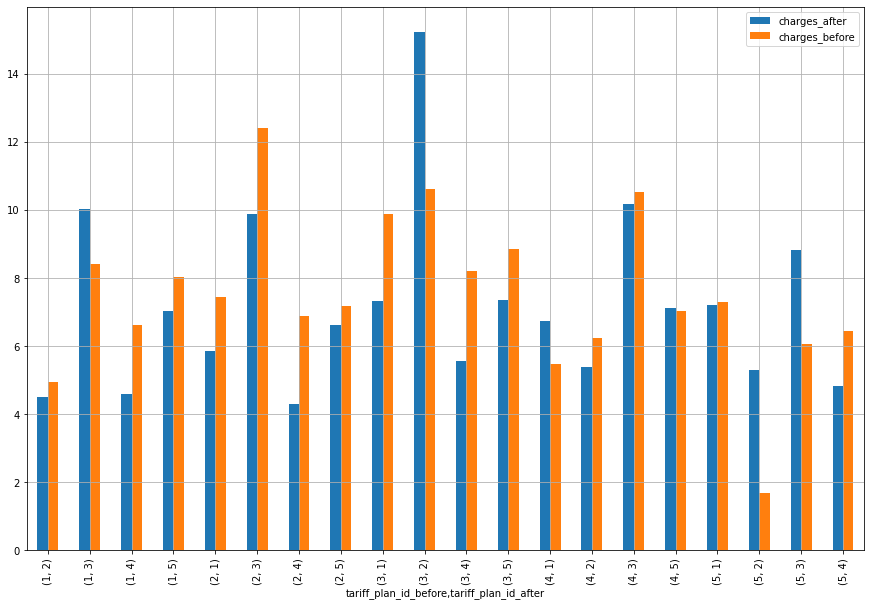

In [41]:
for_plot.plot(
    kind='bar',
    figsize=(15,10),
    grid=True
)

**Блокировки после миграции**

Аналогично п.2, только относительно изменения уровня блокировок: насколько реже или чаще стали попадать в блокировки абоненты после миграции в целом и для каждого направления миграции в отдельности. Для сравнения использовать те же периоды: 3 месяца до месяца смены плана и 3 месяца после месяца смены.

In [42]:
suspended

,SUBSCRIBER_ID,START_DT,END_DT,STATUS
0,5195,2017-12-27,2017-12-27,Suspended
1,5198,2017-04-18,2017-04-18,Suspended
2,381,2017-04-18,2017-04-20,Suspended
3,3500,2017-12-21,$null$,Suspended
4,3302,2016-08-23,2016-09-07,Suspended
...,...,...,...,...
4058,2166,2016-07-23,2016-07-24,Suspended
4059,2166,2016-07-02,2016-07-05,Suspended
4060,2166,2016-06-18,2016-06-21,Suspended
4061,2166,2016-06-11,2016-06-11,Suspended


In [43]:
suspended.columns = suspended.columns.str.lower()

In [44]:
suspended['start_dt'] = pd.to_datetime(suspended['start_dt'], format='%Y-%m-%d', errors='coerce')
suspended['end_dt'] = pd.to_datetime(suspended['end_dt'], format='%Y-%m-%d', errors='coerce')

In [45]:
total_change

,subscriber_id,date_before_3_months,date_after_3_months,tariff_plan_id_before,tariff_plan_id_after,charges_before,charges_after
0,1,2016-12-01,2017-06-01,2,3,21.132,23.651
1,2,2017-03-01,2017-09-01,1,5,5.467,4.984
2,3,2017-01-01,2017-07-01,1,5,4.940,5.044
3,4,2016-10-01,2017-04-01,3,5,6.670,5.310
4,5,2017-02-01,2017-08-01,1,5,4.742,2.804
...,...,...,...,...,...,...,...
6678,5961,2017-02-01,2017-08-01,5,3,0.280,19.404
6679,5963,2017-03-01,2017-09-01,4,5,5.707,5.072
6680,5966,2017-03-01,2017-09-01,4,5,1.120,5.812
6681,5972,2017-03-01,2017-09-01,4,5,1.832,4.964


In [46]:
total_change_suspended = total_change.drop(['charges_before', 'charges_after'], axis=1)

In [47]:
total_change_suspended = total_change_suspended.merge(suspended, left_on=['subscriber_id'], right_on=['subscriber_id'])

In [48]:
total_change_suspended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4216 entries, 0 to 4215
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   subscriber_id          4216 non-null   int64         
 1   date_before_3_months   4216 non-null   datetime64[ns]
 2   date_after_3_months    4216 non-null   datetime64[ns]
 3   tariff_plan_id_before  4216 non-null   int64         
 4   tariff_plan_id_after   4216 non-null   int64         
 5   start_dt               4216 non-null   datetime64[ns]
 6   end_dt                 4149 non-null   datetime64[ns]
 7   status                 4216 non-null   object        
dtypes: datetime64[ns](4), int64(3), object(1)
memory usage: 296.4+ KB


In [49]:
suspended_before = total_change_suspended[total_change_suspended['start_dt'] <= total_change_suspended['date_before_3_months']]

In [50]:
suspended_before

,subscriber_id,date_before_3_months,date_after_3_months,tariff_plan_id_before,tariff_plan_id_after,start_dt,end_dt,status
3,5,2017-02-01,2017-08-01,1,5,2016-11-22,2016-11-28,Suspended
4,5,2017-02-01,2017-08-01,1,5,2016-09-19,2016-09-28,Suspended
5,5,2017-02-01,2017-08-01,1,5,2016-07-25,2016-08-14,Suspended
9,8,2016-11-01,2017-05-01,3,4,2016-09-27,2016-12-05,Suspended
10,8,2016-11-01,2017-05-01,3,4,2016-07-25,2016-08-04,Suspended
...,...,...,...,...,...,...,...,...
4155,5919,2017-02-01,2017-08-01,4,3,2016-12-20,2017-01-08,Suspended
4174,5930,2017-02-01,2017-08-01,4,5,2017-01-24,2017-01-31,Suspended
4179,5935,2017-03-01,2017-09-01,4,5,2017-02-07,2017-02-08,Suspended
4194,5941,2017-03-01,2017-09-01,4,5,2017-02-07,2017-02-19,Suspended


In [51]:
suspended_before = suspended_before.pivot_table('start_dt', index=['subscriber_id', 'tariff_plan_id_before', 'tariff_plan_id_after'], aggfunc='count')

In [52]:
suspended_after = total_change_suspended[total_change_suspended['start_dt'] >= total_change_suspended['date_after_3_months']]

In [53]:
suspended_after = suspended_after.pivot_table('start_dt', index=['subscriber_id', 'tariff_plan_id_before', 'tariff_plan_id_after'], aggfunc='count')

In [54]:
suspended_before

,,,start_dt
subscriber_id,tariff_plan_id_before,tariff_plan_id_after,
5,1,5,3
8,3,4,2
9,3,4,1
29,1,5,4
31,5,4,1
...,...,...,...
5919,4,3,1
5930,4,5,1
5935,4,5,1


In [55]:
suspended_after

start_dt
subscriber_id tariff_plan_id_before tariff_plan_id_after          
8             3                     4                            2
14            3                     5                            1
18            3                     5                            1
20            2                     4                            1
26            3                     5                            1
...                                                            ...
5930          3                     4                            5
              4                     5                            4
5938          4                     5                            1
5955          4                     5                            1
5961          5                     3                            1

[671 rows x 1 columns]

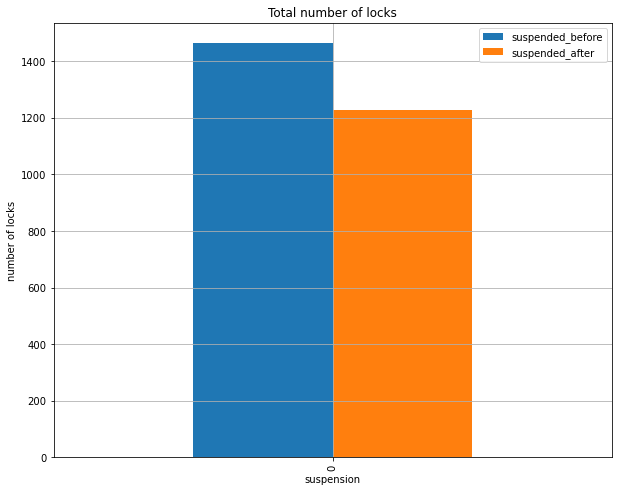

In [56]:
pd.DataFrame(
    {
    'suspended_before': [suspended_before['start_dt'].sum()],
     'suspended_after': [suspended_after['start_dt'].sum()]
    }
).plot(kind='bar',
       title='Total number of locks',
       xlabel='suspension',
       ylabel='number of locks',
       grid=True,
       figsize=(10, 8)
      )
plt.show()

In [57]:
suspended_before_after = suspended_before.merge(suspended_after, how='left', suffixes=['_before', '_after'], on=['subscriber_id', 'tariff_plan_id_before', 'tariff_plan_id_after'])

In [58]:
suspended_before_after

,,,start_dt_before,start_dt_after
subscriber_id,tariff_plan_id_before,tariff_plan_id_after,,
5,1,5,3,NaN
8,3,4,2,2.0
9,3,4,1,NaN
29,1,5,4,NaN
31,5,4,1,NaN
...,...,...,...,...
5919,4,3,1,NaN
5930,4,5,1,4.0
5935,4,5,1,NaN


In [59]:
for_plot1 = suspended_before_after.pivot_table(['start_dt_before', 'start_dt_after'], index=['tariff_plan_id_before', 'tariff_plan_id_after'])

<AxesSubplot:xlabel='tariff_plan_id_before,tariff_plan_id_after'>

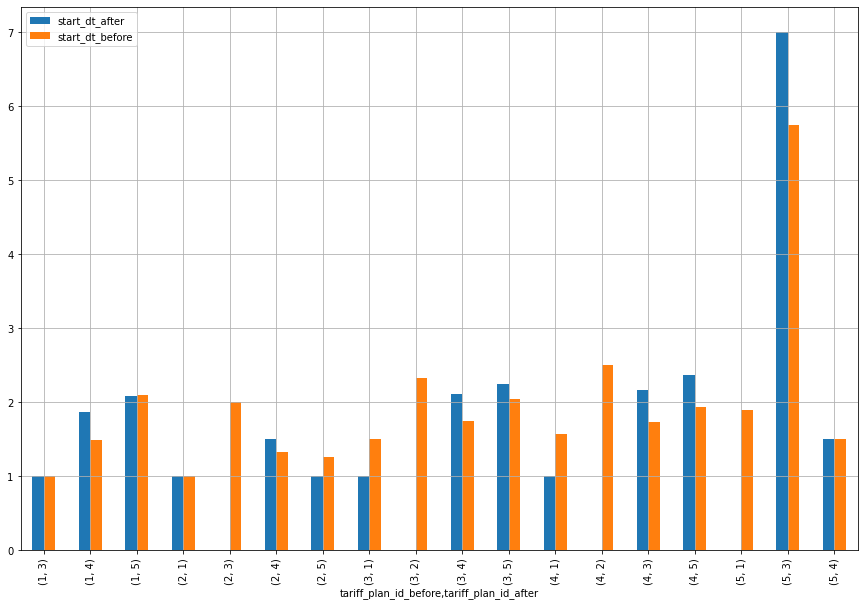

In [60]:
for_plot1.plot(
    kind='bar',
    figsize=(15,10),
    grid=True
              )